<a href="https://colab.research.google.com/github/mudi260/AWS-Slides/blob/main/Frazer_Suzuki_deconv_including_extreactives_C_HM_LG_PR_OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import linregress
from google.colab import files

# Universal gas constant (J/mol·K)
R = 8.314

# Prompt for file upload
print("Please upload 'Opitmization of copyrolysis_input.csv'")
uploaded = files.upload()

# Load the CSV file
df = pd.read_csv('Opitmization of copyrolysis_input.csv')

# Define temperature and alpha ranges
temp_range = [150, 600]  # As requested: 150–600°C
alpha_clip = [0, 1]  # Clip alpha to avoid numerical issues

# Dataframe to store Ea vs alpha data for all SCG:FM ratios
ea_alpha_data = []
# Dataframe to store trend line equations and R² values
trend_line_data = []

# Group by SCG% to process all heating rates for each SCG:FM ratio
for scg, scg_group in df.groupby('SCG%'):
    sample_name = f"SCG:FM {int(scg)}:{int(100-scg)}"
    print(f"\nProcessing {sample_name} across all heating rates...")

    # Store peak temperatures (T_m) for each component across heating rates
    peak_temps = {
        'Hemicellulose': [],
        'Cellulose': [],
        'Lignin': []
    }
    # Only include 'FM' if scg < 100
    if scg < 100:
        peak_temps['FM'] = []

    heating_rates = []
    alpha_ranges = []  # To store alpha ranges for each peak
    r2_values = {}  # To store R² values for each component

    # Process each heating rate for the current SCG%
    for hr, group in scg_group.groupby('Heating rate'):
        print(f"\nProcessing {sample_name}, Heating rate {hr} K/min...")

        # Extract arrays
        temp_c = group['Temperature'].values
        tga = group['TGA'].values
        dtg = group['DTG'].values  # Use experimental DTG from CSV

        # Debug: Check lengths of raw data
        print(f"Raw data lengths - len(temp_c): {len(temp_c)}, len(tga): {len(tga)}, len(dtg): {len(dtg)}")
        if len(temp_c) != len(tga) or len(temp_c) != len(dtg):
            print(f"Length mismatch in raw data. Skipping.")
            continue

        # Filter for the extended temperature range (150–600°C) and ensure finite values
        mask = (temp_c >= temp_range[0]) & (temp_c <= temp_range[1]) & np.isfinite(temp_c) & np.isfinite(tga) & np.isfinite(dtg)
        if not np.any(mask):
            print(f"No data in temperature range {temp_range[0]}–{temp_range[1]}°C. Skipping.")
            continue
        temp_c_full = temp_c[mask]
        tga_full = tga[mask]
        dtg_full = dtg[mask]
        temp_k_full = temp_c_full + 273.15

        # Debug: Check lengths after temperature filter
        print(f"After temp filter - len(temp_c): {len(temp_c_full)}, len(tga): {len(tga_full)}, len(dtg): {len(dtg_full)}")
        if len(temp_c_full) != len(tga_full) or len(temp_c_full) != len(dtg_full):
            print(f"Length mismatch after temperature filter. Skipping.")
            continue


        # Calculate conversion (α) for the full range
        m0 = tga_full[0]
        mf = tga_full[-1]
        if m0 <= mf:
            print(f"Invalid mass loss - m0 ({m0}) <= mf ({mf}). Skipping.")
            continue
        alpha_full = (m0 - tga_full) / (m0 - mf)
        alpha_full = np.clip(alpha_full, alpha_clip[0], alpha_clip[1])

        # Apply alpha filter for deconvolution (α >= 0.1)
        mask_alpha = (alpha_full >= 0.1) & (alpha_full <= 1.0) & np.isfinite(alpha_full)
        if not np.any(mask_alpha):
            print(f"No data for α ≥ 0.1. Alpha range: {alpha_full.min():.4f} to {alpha_full.max():.4f}. Skipping.")
            continue
        alpha = alpha_full[mask_alpha]
        temp_k = temp_k_full[mask_alpha]
        temp_c = temp_c_full[mask_alpha]
        tga = tga_full[mask_alpha]
        dtg = dtg_full[mask_alpha]

        # Debug: Check lengths after alpha filter
        print(f"After alpha filter - len(temp_c): {len(temp_c)}, len(tga): {len(tga)}, len(dtg): {len(dtg)}")
        if len(temp_c) != len(tga) or len(temp_c) != len(dtg):
            print(f"Length mismatch after alpha filter. Skipping.")
            continue

        # Check for non-finite values in temp_c and dtg
        if not np.all(np.isfinite(temp_c)) or not np.all(np.isfinite(dtg)):
            print(f"Non-finite values detected in temp_c or dtg after filtering. Skipping.")
            continue

        # Ensure enough data points for processing
        if len(dtg) < 3:
            print(f"Not enough data points after filtering (len(dtg) = {len(dtg)}). Skipping.")
            continue

        # Fraser-Suzuki deconvolution without ci weighting factor
        def fraser_suzuki(x, h, r, wr, sr):
            arg = (x - r) * sr / wr
            arg_safe = np.where(arg > -1, arg, -0.9999)  # Prevent log of negative numbers
            term = np.log(1 + arg_safe)
            exponent = -np.log(2) * (term / sr)**2
            exponent = np.clip(exponent, -500, 500)  # Prevent overflow in exp
            return h * np.exp(exponent)

        def multi_fraser_suzuki(x, *params):
            n_peaks = len(params) // 4  # 4 parameters per peak (h, r, wr, sr)
            y = np.zeros_like(x, dtype=float)
            for i in range(n_peaks):
                y += fraser_suzuki(x, *params[i*4:i*4+4])
            return y

        # Set number of peaks and initial guesses based on decomposition ranges
        n_peaks = 3 if scg > 0 else 1  # SCG: 3 peaks (hemicellulose, cellulose, lignin); FM: 1 peak
        dtg_max = dtg.max()
        initial_guesses = []
        if scg > 0:
            # Order: h, r, wr, sr
            # Hemicellulose: 220–310°C
            initial_guesses.extend([dtg_max * 0.3, 265, 30, 0.5])
            # Cellulose: 250–400°C
            initial_guesses.extend([dtg_max, 325, 30, 0.5])
            # Lignin: 220–600°C
            initial_guesses.extend([dtg_max * 0.4, 400, 100, 0.5])
        if scg < 100:
            if scg == 0:
                # FM only: 460–480°C
                initial_guesses = [dtg_max, 470, 20, 0.5]
            else:
                # FM in blends: 460–480°C
                initial_guesses.extend([dtg_max * 0.5, 470, 20, 0.5])

        # Define bounds for curve_fit based on decomposition ranges
        bounds_lower = []
        bounds_upper = []
        if scg > 0:
            # Hemicellulose: h, r, wr, sr
            bounds_lower.extend([0, 220, 10, 0.1])
            bounds_upper.extend([np.inf, 310, 50, 2.0])
            # Cellulose: 250–400°C
            bounds_lower.extend([0, 250, 10, 0.1])
            bounds_upper.extend([np.inf, 400, 50, 2.0])
            # Lignin: 220–600°C
            bounds_lower.extend([0, 220, 50, 0.1])
            bounds_upper.extend([np.inf, 600, 150, 2.0])
        if scg < 100:
            if scg == 0:
                # FM only
                bounds_lower = [0, 460, 10, 0.1]
                bounds_upper = [np.inf, 480, 30, 2.0]
            else:
                # FM in blends
                bounds_lower.extend([0, 460, 10, 0.1])
                bounds_upper.extend([np.inf, 480, 30, 2.0])
        bounds = (bounds_lower, bounds_upper)

        try:
            popt, _ = curve_fit(multi_fraser_suzuki, temp_c, dtg, p0=initial_guesses, bounds=bounds, maxfev=10000)
            print(f"{sample_name}: Fraser-Suzuki deconvolution successful at {hr} K/min.")
            component_labels = []
            if scg > 0:
                component_labels.extend(['Hemicellulose', 'Cellulose', 'Lignin'])
            if scg < 100:
                if scg == 0:
                    component_labels = ['FM']
                else:
                    component_labels.append('FM')
            for i in range(len(popt) // 4):
                print(f"Peak {i+1} ({component_labels[i]}): Height: {popt[i*4]:.4f}, Position: {popt[i*4+1]:.2f}°C, Width: {popt[i*4+2]:.2f}, Asymmetry: {popt[i*4+3]:.2f}")
        except RuntimeError as e:
            print(f"{sample_name}: Fraser-Suzuki deconvolution failed at {hr} K/min: {e}. Skipping.")
            continue

        # Generate a temperature array from 150 to 600°C for plotting and peak analysis
        temp_c_plot = np.linspace(150, 600, len(temp_c_full))
        deconvoluted_peaks = [fraser_suzuki(temp_c_plot, *popt[i*4:i*4+4]) for i in range(len(popt) // 4)]

        # Map peaks to alpha ranges and collect T_m for Ea calculation
        current_alpha_ranges = []
        for i, (peak, label) in enumerate(zip(deconvoluted_peaks, component_labels)):
            # Find peak maximum temperature (T_m)
            peak_max_idx = np.argmax(peak)
            T_m = temp_c_plot[peak_max_idx]  # Peak temperature in °C
            T_m_kelvin = T_m + 273.15  # Convert to Kelvin for Ea calculation
            peak_temps[label].append(T_m_kelvin)

            # Determine temperature range where peak is significant (e.g., >5% of max height)
            threshold = 0.05 * peak[peak_max_idx]
            significant_indices = np.where(peak > threshold)[0]
            if len(significant_indices) == 0:
                print(f"Warning: No significant range found for {label} at {hr} K/min.")
                continue
            temp_start = temp_c_plot[significant_indices[0]]
            temp_end = temp_c_plot[significant_indices[-1]]

            # Map temperature range to alpha range using temp_c_full and alpha_full
            alpha_mask = (temp_c_full >= temp_start) & (temp_c_full <= temp_end)
            if not np.any(alpha_mask):
                print(f"Warning: No alpha values found for {label} in range {temp_start:.1f}–{temp_end:.1f}°C at {hr} K/min.")
                continue
            alpha_range = (alpha_full[alpha_mask].min(), alpha_full[alpha_mask].max())
            current_alpha_ranges.append((label, alpha_range))
            print(f"{label} at {hr} K/min: Alpha range = {alpha_range[0]:.3f} to {alpha_range[1]:.3f}")

        alpha_ranges.append(current_alpha_ranges)
        heating_rates.append(hr)

        # Plotting DTG deconvolution
        plt.figure(figsize=(8, 6))
        plt.plot(temp_c_full, dtg_full, 'ks', label='Experimental', markersize=4)
        if scg == 0:
            labels = ['P-FM']
            colors = ['cyan']
        elif scg == 100:
            labels = ['P-HM', 'P-CE', 'P-LG']
            colors = ['pink', 'yellow', 'lightgreen']
        else:
            labels = ['P-HM', 'P-CE', 'P-LG', 'P-FM']
            colors = ['pink', 'yellow', 'lightgreen', 'cyan']
        for i, (peak, label, color) in enumerate(zip(deconvoluted_peaks, labels[:len(deconvoluted_peaks)], colors)):
            plt.fill_between(temp_c_plot, 0, peak, color=color, alpha=0.5, label=label)
            peak_max_idx = np.argmax(peak)
            plt.text(temp_c_plot[peak_max_idx], peak[peak_max_idx], f'Peak {i+1}', ha='center', va='bottom')
        fit = multi_fraser_suzuki(temp_c_plot, *popt)
# R2 for calculating R² for deconvolution fit
        y_true = dtg_full  # experimental DTG
        y_pred = multi_fraser_suzuki(temp_c_full, *popt)  # fitted DTG using same x-points
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2_deconv = 1 - (ss_res / ss_tot)

        print(f"Deconvolution R² at {hr} K/min for {sample_name}: {r2_deconv:.4f}")

        plt.plot(temp_c_plot, fit, 'g-', label='Fit')
        plt.xlim(150, 600)
        plt.xlabel('Temperature/°C')
        plt.ylabel('dα/dt')
        plt.title(f'DTG Deconvolution for {sample_name} at {hr} K/min')
        plt.legend()
        plt.grid(True)
        filename = f'deconvolution_dtg_scg{int(scg)}_hr{int(hr)}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        files.download(filename)

        # Stage detection
        dtg_deconv = multi_fraser_suzuki(temp_c, *popt)
        peaks, _ = find_peaks(dtg_deconv, prominence=0.01 * dtg_deconv.max())
        troughs, _ = find_peaks(-dtg_deconv, prominence=0.01 * dtg_deconv.max())
        critical_points = sorted(list(peaks) + list(troughs))
        critical_points = [0] + critical_points + [len(dtg) - 1]
        critical_points = sorted(list(set(critical_points)))

        alpha_critical = alpha[critical_points]
        stages = []
        for i in range(len(alpha_critical) - 1):
            alpha_start, alpha_end = alpha_critical[i], alpha_critical[i + 1]
            if alpha_end - alpha_start < 0.05:
                continue
            stages.append((alpha_start, alpha_end))
            print(f"{sample_name}: Stage {i+1} at {hr} K/min: α = {alpha_start:.3f} to {alpha_end:.3f}")

        if not stages:
            print(f"{sample_name}: No stages detected at {hr} K/min. Using fallback stage.")
            stages = [(alpha.min(), alpha.max())]
        print(f"{sample_name}: Stages for Criado plots at {hr} K/min: {stages}")


    # Calculate Ea for each component using the Kissinger method
    print(f"\nCalculating Ea for {sample_name}...")
    ea_alpha_components = []
    for component, t_m_values in peak_temps.items():
        if len(t_m_values) < 2:
            print(f"Insufficient data to calculate Ea for {component} (need at least 2 heating rates).")
            continue

        # Prepare data for Kissinger method: ln(beta/T_m^2) vs 1/T_m
        x = 1 / np.array(t_m_values)  # 1/T_m (K^-1)
        y = np.log(np.array(heating_rates) / np.array(t_m_values)**2)  # ln(beta/T_m^2)

        # Linear regression to find slope (-Ea/R) and intercept
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        Ea = -slope * R / 1000  # Ea in kJ/mol
        r2 = r_value**2
        r2_values[component] = r2

        # Format the trend line equation: y = mx + b
        trend_line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
        print(f"{component}: Ea = {Ea:.2f} kJ/mol (R² = {r2:.4f}, Trend Line: {trend_line_eq})")

        # Store trend line data
        trend_line_data.append({
            'SCG:FM Ratio': sample_name,
            'Component': component,
            'Trend Line Equation': trend_line_eq,
            'R²': r2
        })

        # Plot Kissinger plot for visualization
        plt.figure(figsize=(6, 4))
        plt.scatter(x, y, color='blue', label='Data')
        plt.plot(x, slope * x + intercept, 'r-', label=f'Fit (Ea = {Ea:.2f} kJ/mol)')
        plt.xlabel('1/T_m (K⁻¹)')
        plt.ylabel('ln(β/T_m²)')
        plt.title(f'Kissinger Plot for {component} ({sample_name})')
        plt.legend()
        plt.grid(True)
        filename = f'kissinger_plot_{component}_scg{int(scg)}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        files.download(filename)

        ea_alpha_components.append((component, Ea))

    # Summarize alpha ranges (using the last heating rate as a reference)
    print(f"\nAlpha ranges for {sample_name} (based on last heating rate processed):")
    if alpha_ranges:
        for label, (alpha_start, alpha_end) in alpha_ranges[-1]:
            print(f"{label}: α = {alpha_start:.3f} to {alpha_end:.3f}")

            # Find the corresponding Ea and R² for this component
            Ea = next((ea for comp, ea in ea_alpha_components if comp == label), None)
            r2 = r2_values.get(label, None)
            if Ea is not None and r2 is not None:
                alpha_mid = (alpha_start + alpha_end) / 2
                ea_alpha_data.append({
                    'SCG:FM Ratio': sample_name,
                    'Component': label,
                    'Alpha Start': alpha_start,
                    'Alpha End': alpha_end,
                    'Alpha Midpoint': alpha_mid,
                    'Ea (kJ/mol)': Ea,
                    'R²': r2
                })

    # Plot Ea vs Alpha for the current SCG:FM ratio
    if alpha_ranges and ea_alpha_components:
        plt.figure(figsize=(8, 6))
        for label, (alpha_start, alpha_end) in alpha_ranges[-1]:
            Ea = next((ea for comp, ea in ea_alpha_components if comp == label), None)
            r2 = r2_values.get(label, None)
            if Ea is not None and r2 is not None:
                alpha_mid = (alpha_start + alpha_end) / 2
                plt.scatter(alpha_mid, Ea, label=f'{label} (R² = {r2:.4f})', s=100)
                plt.text(alpha_mid, Ea + 5, label, ha='center', va='bottom')
        plt.xlabel('Conversion (α)')
        plt.ylabel('Activation Energy (Ea, kJ/mol)')
        plt.title(f'Activation Energy vs Conversion for {sample_name}')
        plt.grid(True)
        plt.legend()
        plt.savefig(f'ea_vs_alpha_scg{int(scg)}.png', dpi=300, bbox_inches='tight')
        plt.show()
        files.download(f'ea_vs_alpha_scg{int(scg)}.png')

# Create and download CSV file with Ea vs Alpha data
if ea_alpha_data:
    ea_alpha_df = pd.DataFrame(ea_alpha_data)
    csv_filename = 'ea_vs_alpha_data.csv'
    ea_alpha_df.to_csv(csv_filename, index=False)
    print(f"\nDownloading {csv_filename}...")
    files.download(csv_filename)
else:
    print("\nNo Ea vs Alpha data to export.")

# Create and download CSV file with trend line equations and R² values
if trend_line_data:
    trend_line_df = pd.DataFrame(trend_line_data)
    trend_csv_filename = 'trend_lines.csv'
    trend_line_df.to_csv(trend_csv_filename, index=False)
    print(f"\nDownloading {trend_csv_filename}...")
    files.download(trend_csv_filename)
else:
    print("\nNo trend line data to export.")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 286)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Please upload 'Opitmization of copyrolysis_input.csv'


Saving Opitmization of copyrolysis_input.csv to Opitmization of copyrolysis_input.csv

Processing SCG:FM 0:100 across all heating rates...

Processing SCG:FM 0:100, Heating rate 5 K/min...
Raw data lengths - len(temp_c): 5401, len(tga): 5401, len(dtg): 5401
After temp filter - len(temp_c): 5401, len(tga): 5401, len(dtg): 5401
After alpha filter - len(temp_c): 2273, len(tga): 2273, len(dtg): 2273
SCG:FM 0:100: Fraser-Suzuki deconvolution successful at 5 K/min.
Peak 1 (FM): Height: 0.1331, Position: 460.00°C, Width: 27.34, Asymmetry: 0.10
R² for fit at 5 K/min: 0.4403
FM at 5 K/min: Alpha range = 0.093 to 0.999


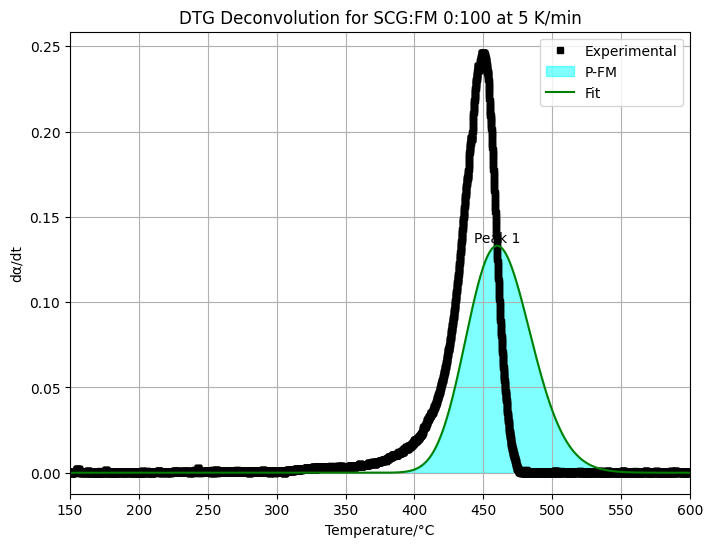

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 0:100...
Insufficient heating rates for FM to apply KAS method (need at least 2).

Processing SCG:FM 0:100, Heating rate 10 K/min...
Raw data lengths - len(temp_c): 2699, len(tga): 2699, len(dtg): 2699
After temp filter - len(temp_c): 2699, len(tga): 2699, len(dtg): 2699
After alpha filter - len(temp_c): 1039, len(tga): 1039, len(dtg): 1039
SCG:FM 0:100: Fraser-Suzuki deconvolution successful at 10 K/min.
Peak 1 (FM): Height: 0.4683, Position: 460.08°C, Width: 14.82, Asymmetry: 0.10
R² for fit at 10 K/min: 0.9632
FM at 10 K/min: Alpha range = 0.127 to 1.000


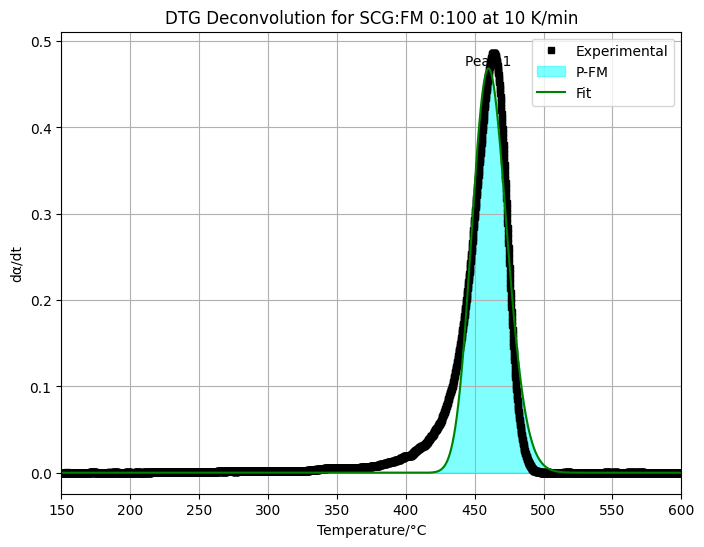

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 0:100...
FM at α = 0.177: Ea = 332.47 kJ/mol (R² = 1.0000)
FM at α = 0.227: Ea = 418.24 kJ/mol (R² = 1.0000)
FM at α = 0.277: Ea = 557.35 kJ/mol (R² = 1.0000)
FM at α = 0.327: Ea = 769.78 kJ/mol (R² = 1.0000)
FM at α = 0.377: Ea = 1267.14 kJ/mol (R² = 1.0000)
FM at α = 0.427: Ea = 2890.19 kJ/mol (R² = 1.0000)
FM at α = 0.477: Ea = -16621.70 kJ/mol (R² = 1.0000)
FM at α = 0.527: Ea = -1959.70 kJ/mol (R² = 1.0000)
FM at α = 0.577: Ea = -1082.42 kJ/mol (R² = 1.0000)
FM at α = 0.627: Ea = -738.89 kJ/mol (R² = 1.0000)
FM at α = 0.677: Ea = -564.33 kJ/mol (R² = 1.0000)
FM at α = 0.727: Ea = -439.00 kJ/mol (R² = 1.0000)
FM at α = 0.777: Ea = -361.35 kJ/mol (R² = 1.0000)
FM at α = 0.827: Ea = -302.18 kJ/mol (R² = 1.0000)
FM at α = 0.877: Ea = -250.92 kJ/mol (R² = 1.0000)
FM at α = 0.927: Ea = -204.05 kJ/mol (R² = 1.0000)
FM at α = 0.977: Ea = -156.58 kJ/mol (R² = 1.0000)

Processing SCG:FM 0:100, Heating rate 20 K/min...
Raw data lengths - len(temp_c): 1351, len

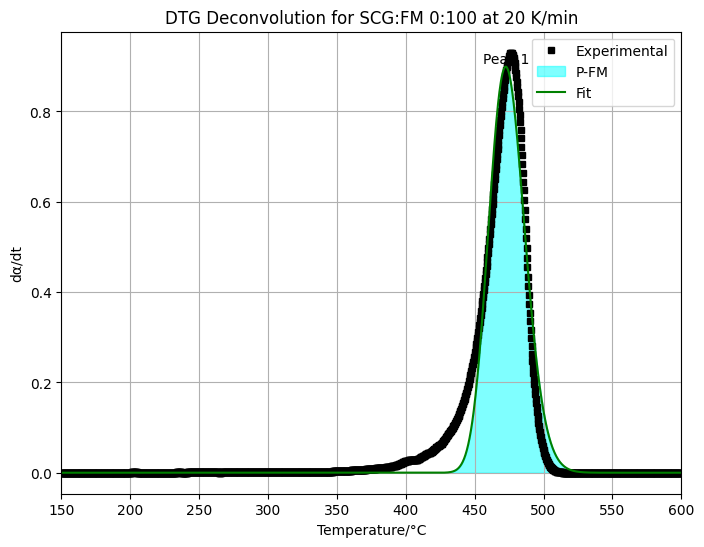

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 0:100...
FM at α = 0.177: Ea = 274.83 kJ/mol (R² = 0.9908)
FM at α = 0.227: Ea = 300.71 kJ/mol (R² = 0.9767)
FM at α = 0.277: Ea = 320.91 kJ/mol (R² = 0.9492)
FM at α = 0.327: Ea = 344.27 kJ/mol (R² = 0.9163)
FM at α = 0.377: Ea = 357.44 kJ/mol (R² = 0.8627)
FM at α = 0.427: Ea = 368.67 kJ/mol (R² = 0.8000)
FM at α = 0.477: Ea = 373.03 kJ/mol (R² = 0.7255)
FM at α = 0.527: Ea = 362.23 kJ/mol (R² = 0.6238)
FM at α = 0.577: Ea = 344.53 kJ/mol (R² = 0.5133)
FM at α = 0.627: Ea = 310.56 kJ/mol (R² = 0.3875)
FM at α = 0.677: Ea = 261.43 kJ/mol (R² = 0.2704)
FM at α = 0.727: Ea = 191.17 kJ/mol (R² = 0.1474)
FM at α = 0.777: Ea = 112.74 kJ/mol (R² = 0.0521)
FM at α = 0.827: Ea = 37.05 kJ/mol (R² = 0.0063)
FM at α = 0.877: Ea = -42.19 kJ/mol (R² = 0.0097)
FM at α = 0.927: Ea = -100.18 kJ/mol (R² = 0.0730)
FM at α = 0.977: Ea = -136.69 kJ/mol (R² = 0.2185)

Processing SCG:FM 0:100, Heating rate 30 K/min...
Raw data lengths - len(temp_c): 901, len(tga): 901, len(d

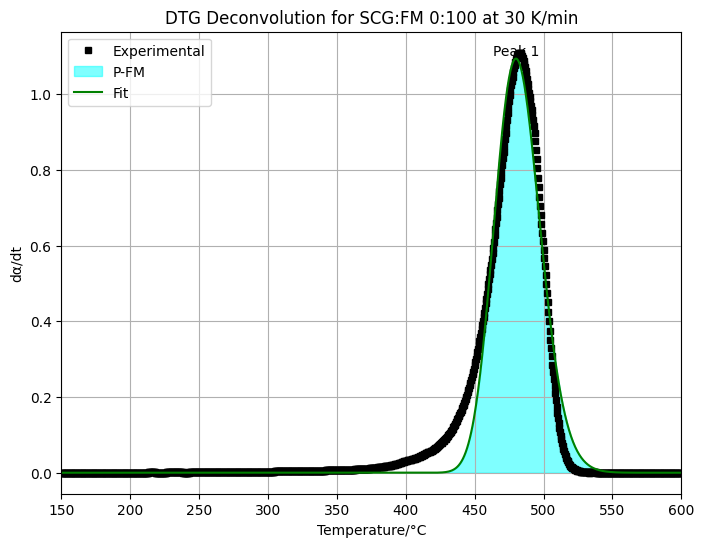

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 0:100...
FM at α = 0.177: Ea = 286.07 kJ/mol (R² = 0.9933)
FM at α = 0.227: Ea = 303.24 kJ/mol (R² = 0.9879)
FM at α = 0.277: Ea = 313.79 kJ/mol (R² = 0.9733)
FM at α = 0.327: Ea = 321.72 kJ/mol (R² = 0.9530)
FM at α = 0.377: Ea = 327.79 kJ/mol (R² = 0.9234)
FM at α = 0.427: Ea = 333.41 kJ/mol (R² = 0.8896)
FM at α = 0.477: Ea = 336.04 kJ/mol (R² = 0.8508)
FM at α = 0.527: Ea = 325.54 kJ/mol (R² = 0.7978)
FM at α = 0.577: Ea = 321.93 kJ/mol (R² = 0.7427)
FM at α = 0.627: Ea = 314.41 kJ/mol (R² = 0.6775)
FM at α = 0.677: Ea = 298.86 kJ/mol (R² = 0.6107)
FM at α = 0.727: Ea = 277.53 kJ/mol (R² = 0.5254)
FM at α = 0.777: Ea = 254.47 kJ/mol (R² = 0.4318)
FM at α = 0.827: Ea = 221.32 kJ/mol (R² = 0.3429)
FM at α = 0.877: Ea = 178.62 kJ/mol (R² = 0.2370)
FM at α = 0.927: Ea = 124.33 kJ/mol (R² = 0.1297)
FM at α = 0.977: Ea = 47.30 kJ/mol (R² = 0.0233)

Processing SCG:FM 25:75 across all heating rates...

Processing SCG:FM 25:75, Heating rate 5 K/min...
Raw dat

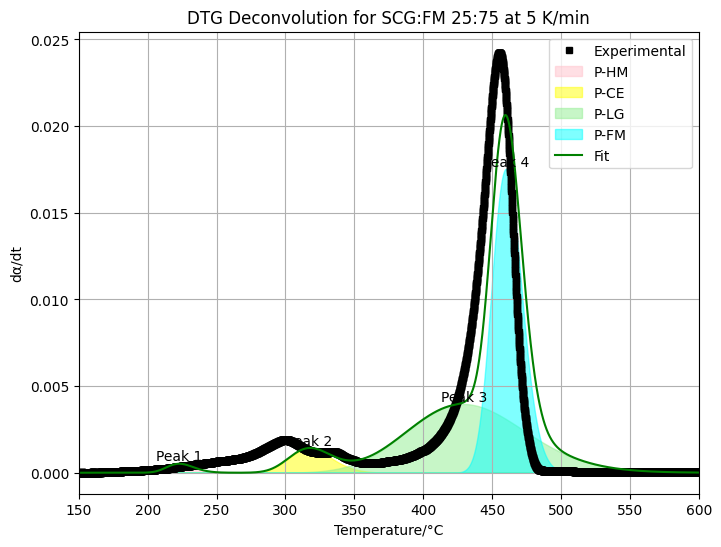

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 25:75...
Insufficient heating rates for Hemicellulose to apply KAS method (need at least 2).
Insufficient heating rates for Cellulose to apply KAS method (need at least 2).
Insufficient heating rates for Lignin to apply KAS method (need at least 2).
Insufficient heating rates for FM to apply KAS method (need at least 2).

Processing SCG:FM 25:75, Heating rate 10 K/min...
Raw data lengths - len(temp_c): 2701, len(tga): 2701, len(dtg): 2701
After temp filter - len(temp_c): 2701, len(tga): 2701, len(dtg): 2701
After alpha filter - len(temp_c): 1701, len(tga): 1701, len(dtg): 1701
SCG:FM 25:75: Fraser-Suzuki deconvolution successful at 10 K/min.
Peak 1 (Hemicellulose): Height: 0.0000, Position: 220.00°C, Width: 10.00, Asymmetry: 0.10
Peak 2 (Cellulose): Height: 0.0041, Position: 288.33°C, Width: 20.07, Asymmetry: 0.53
Peak 3 (Lignin): Height: 0.0022, Position: 434.40°C, Width: 50.00, Asymmetry: 0.10
Peak 4 (FM): Height: 0.0203, Position: 465.29°C, Width: 13.

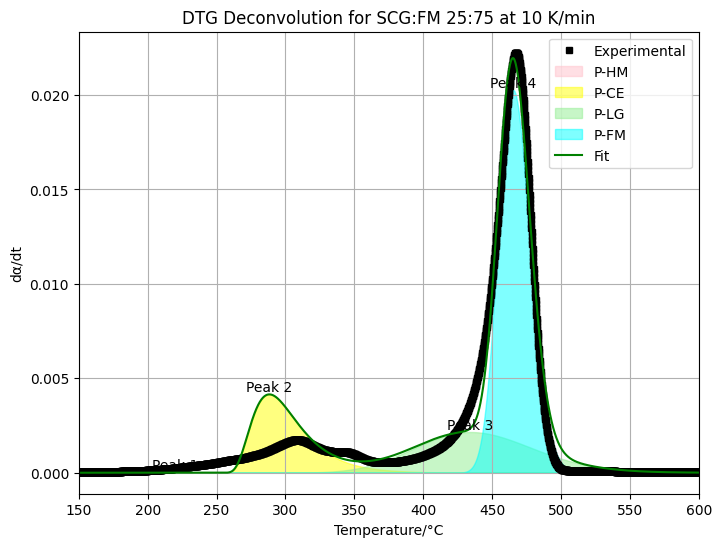

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 25:75...
No alpha points selected for Hemicellulose in range 0.003 to 0.016. Skipping.
Cellulose at α = 0.103: Ea = -87.70 kJ/mol (R² = 1.0000)
Cellulose at α = 0.153: Ea = -87.25 kJ/mol (R² = 1.0000)
Lignin at α = 0.186: Ea = 509.02 kJ/mol (R² = 1.0000)
Lignin at α = 0.236: Ea = 511.03 kJ/mol (R² = 1.0000)
Lignin at α = 0.286: Ea = 529.39 kJ/mol (R² = 1.0000)
Lignin at α = 0.336: Ea = 529.46 kJ/mol (R² = 1.0000)
Lignin at α = 0.386: Ea = 547.24 kJ/mol (R² = 1.0000)
Lignin at α = 0.436: Ea = 565.43 kJ/mol (R² = 1.0000)
Lignin at α = 0.486: Ea = 555.07 kJ/mol (R² = 1.0000)
Lignin at α = 0.536: Ea = 563.57 kJ/mol (R² = 1.0000)
Lignin at α = 0.586: Ea = 572.39 kJ/mol (R² = 1.0000)
Lignin at α = 0.636: Ea = 591.52 kJ/mol (R² = 1.0000)
Lignin at α = 0.686: Ea = 601.47 kJ/mol (R² = 1.0000)
Lignin at α = 0.736: Ea = 602.31 kJ/mol (R² = 1.0000)
Lignin at α = 0.786: Ea = 614.50 kJ/mol (R² = 1.0000)
Lignin at α = 0.836: Ea = 639.53 kJ/mol (R² = 1.0000)
Lignin at α

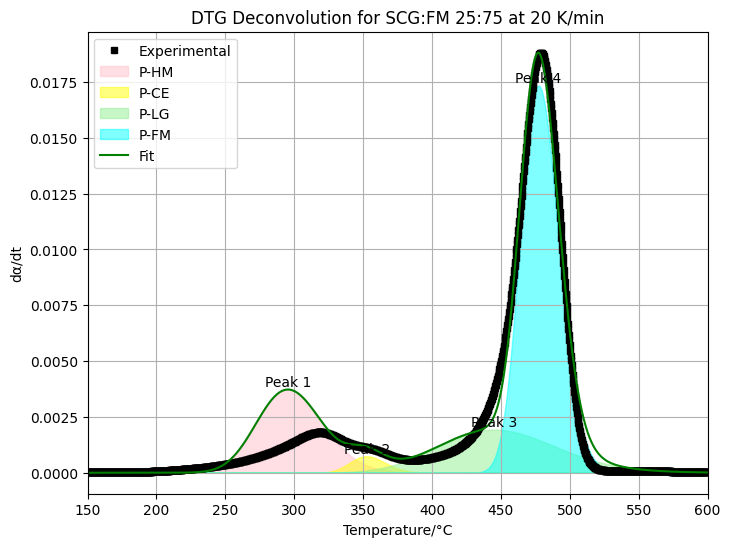

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 25:75...
No alpha points selected for Hemicellulose in range 0.009 to 0.016. Skipping.
Cellulose at α = 0.149: Ea = 27.52 kJ/mol (R² = 0.2244)
Lignin at α = 0.188: Ea = 316.89 kJ/mol (R² = 0.9592)
Lignin at α = 0.238: Ea = 319.44 kJ/mol (R² = 0.9576)
Lignin at α = 0.288: Ea = 324.21 kJ/mol (R² = 0.9593)
Lignin at α = 0.338: Ea = 330.93 kJ/mol (R² = 0.9576)
Lignin at α = 0.388: Ea = 343.51 kJ/mol (R² = 0.9624)
Lignin at α = 0.438: Ea = 340.31 kJ/mol (R² = 0.9593)
Lignin at α = 0.488: Ea = 346.90 kJ/mol (R² = 0.9576)
Lignin at α = 0.538: Ea = 352.20 kJ/mol (R² = 0.9576)
Lignin at α = 0.588: Ea = 362.16 kJ/mol (R² = 0.9592)
Lignin at α = 0.638: Ea = 371.24 kJ/mol (R² = 0.9624)
Lignin at α = 0.688: Ea = 369.69 kJ/mol (R² = 0.9577)
Lignin at α = 0.738: Ea = 384.45 kJ/mol (R² = 0.9625)
Lignin at α = 0.788: Ea = 382.63 kJ/mol (R² = 0.9593)
Lignin at α = 0.838: Ea = 401.48 kJ/mol (R² = 0.9625)
Lignin at α = 0.888: Ea = 404.51 kJ/mol (R² = 0.9577)
Lignin at α = 0

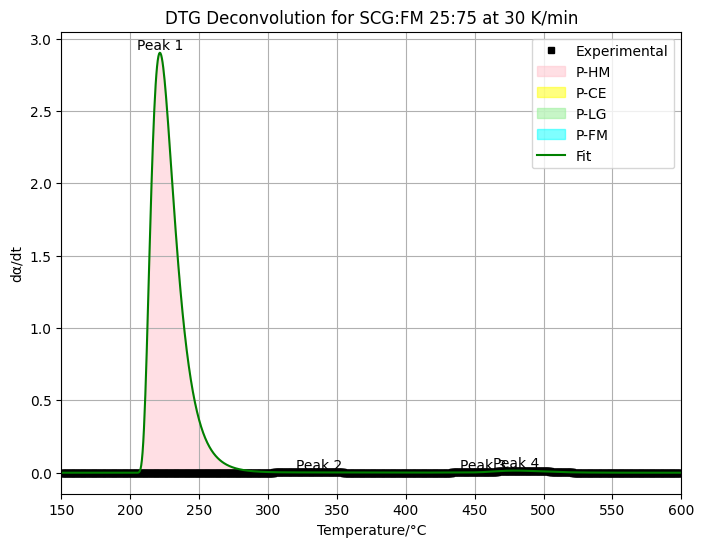

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 25:75...
No alpha points selected for Hemicellulose in range 0.009 to 0.016. Skipping.
Cellulose at α = 0.149: Ea = 33.16 kJ/mol (R² = 0.1574)
Lignin at α = 0.228: Ea = 244.71 kJ/mol (R² = 0.9386)
Lignin at α = 0.278: Ea = 252.70 kJ/mol (R² = 0.9417)
Lignin at α = 0.328: Ea = 256.01 kJ/mol (R² = 0.9369)
Lignin at α = 0.378: Ea = 260.99 kJ/mol (R² = 0.9410)
Lignin at α = 0.428: Ea = 263.78 kJ/mol (R² = 0.9382)
Lignin at α = 0.478: Ea = 266.54 kJ/mol (R² = 0.9353)
Lignin at α = 0.528: Ea = 274.98 kJ/mol (R² = 0.9445)
Lignin at α = 0.578: Ea = 278.38 kJ/mol (R² = 0.9405)
Lignin at α = 0.628: Ea = 280.15 kJ/mol (R² = 0.9395)
Lignin at α = 0.678: Ea = 289.51 kJ/mol (R² = 0.9420)
Lignin at α = 0.728: Ea = 294.37 kJ/mol (R² = 0.9414)
Lignin at α = 0.778: Ea = 296.52 kJ/mol (R² = 0.9389)
Lignin at α = 0.828: Ea = 306.75 kJ/mol (R² = 0.9433)
Lignin at α = 0.878: Ea = 313.00 kJ/mol (R² = 0.9390)
Lignin at α = 0.928: Ea = 332.73 kJ/mol (R² = 0.9413)
Lignin at α = 0

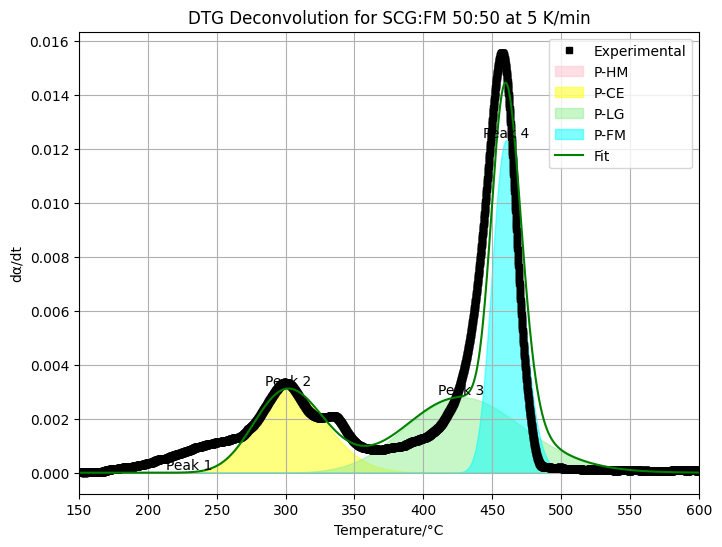

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 50:50...
Insufficient heating rates for Hemicellulose to apply KAS method (need at least 2).
Insufficient heating rates for Cellulose to apply KAS method (need at least 2).
Insufficient heating rates for Lignin to apply KAS method (need at least 2).
Insufficient heating rates for FM to apply KAS method (need at least 2).

Processing SCG:FM 50:50, Heating rate 10 K/min...
Raw data lengths - len(temp_c): 2701, len(tga): 2701, len(dtg): 2701
After temp filter - len(temp_c): 2701, len(tga): 2701, len(dtg): 2701
After alpha filter - len(temp_c): 1875, len(tga): 1875, len(dtg): 1875
SCG:FM 50:50: Fraser-Suzuki deconvolution successful at 10 K/min.
Peak 1 (Hemicellulose): Height: 0.0000, Position: 220.13°C, Width: 10.72, Asymmetry: 1.06
Peak 2 (Cellulose): Height: 0.0031, Position: 310.85°C, Width: 31.78, Asymmetry: 0.10
Peak 3 (Lignin): Height: 0.0020, Position: 433.43°C, Width: 50.00, Asymmetry: 0.10
Peak 4 (FM): Height: 0.0128, Position: 466.08°C, Width: 14.

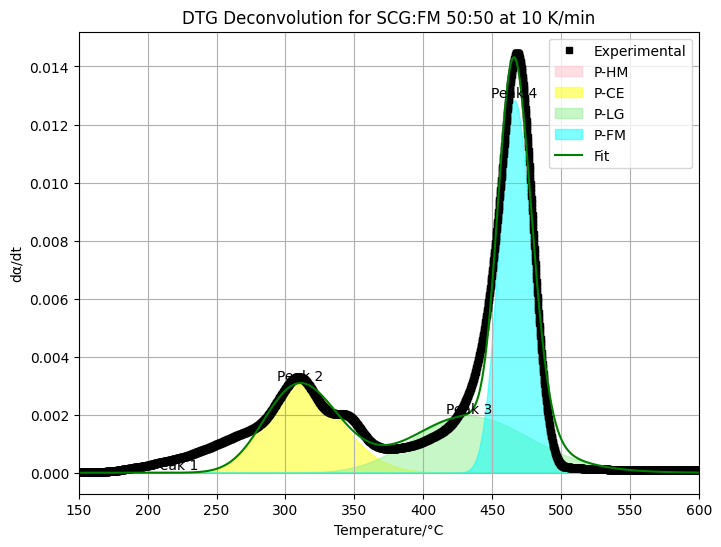

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 50:50...
Hemicellulose at α = 0.064: Ea = -455.72 kJ/mol (R² = 1.0000)
Cellulose at α = 0.097: Ea = 237.11 kJ/mol (R² = 1.0000)
Cellulose at α = 0.147: Ea = 228.40 kJ/mol (R² = 1.0000)
Cellulose at α = 0.197: Ea = 227.16 kJ/mol (R² = 1.0000)
Cellulose at α = 0.247: Ea = 223.07 kJ/mol (R² = 1.0000)
Cellulose at α = 0.297: Ea = 221.26 kJ/mol (R² = 1.0000)
Lignin at α = 0.320: Ea = 466.48 kJ/mol (R² = 1.0000)
Lignin at α = 0.370: Ea = 467.32 kJ/mol (R² = 1.0000)
Lignin at α = 0.420: Ea = 489.27 kJ/mol (R² = 1.0000)
Lignin at α = 0.470: Ea = 482.40 kJ/mol (R² = 1.0000)
Lignin at α = 0.520: Ea = 489.91 kJ/mol (R² = 1.0000)
Lignin at α = 0.570: Ea = 505.00 kJ/mol (R² = 1.0000)
Lignin at α = 0.620: Ea = 513.23 kJ/mol (R² = 1.0000)
Lignin at α = 0.670: Ea = 514.25 kJ/mol (R² = 1.0000)
Lignin at α = 0.720: Ea = 531.38 kJ/mol (R² = 1.0000)
Lignin at α = 0.770: Ea = 550.12 kJ/mol (R² = 1.0000)
Lignin at α = 0.820: Ea = 554.14 kJ/mol (R² = 1.0000)
Lignin at α = 0.87

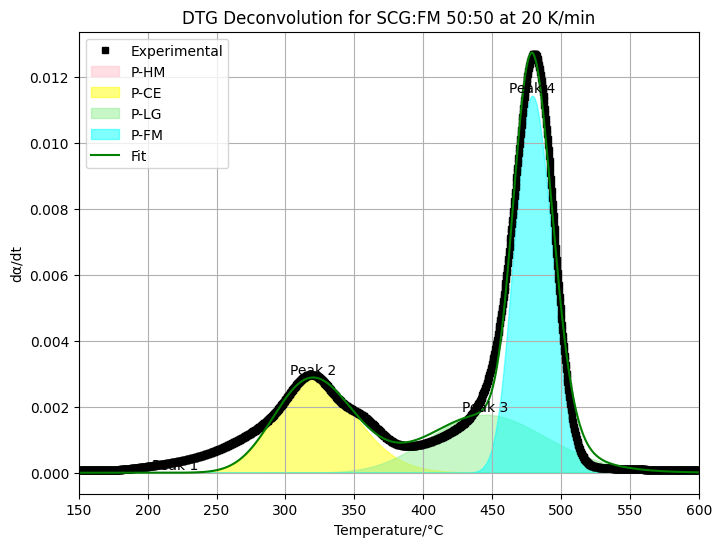

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 50:50...
No alpha points selected for Hemicellulose in range 0.014 to 0.025. Skipping.
Cellulose at α = 0.097: Ea = 247.04 kJ/mol (R² = 0.9994)
Cellulose at α = 0.147: Ea = 236.38 kJ/mol (R² = 0.9996)
Cellulose at α = 0.197: Ea = 235.02 kJ/mol (R² = 0.9996)
Cellulose at α = 0.247: Ea = 229.49 kJ/mol (R² = 0.9997)
Cellulose at α = 0.297: Ea = 222.90 kJ/mol (R² = 1.0000)
Lignin at α = 0.320: Ea = 296.21 kJ/mol (R² = 0.9617)
Lignin at α = 0.370: Ea = 300.07 kJ/mol (R² = 0.9631)
Lignin at α = 0.420: Ea = 307.00 kJ/mol (R² = 0.9602)
Lignin at α = 0.470: Ea = 313.10 kJ/mol (R² = 0.9645)
Lignin at α = 0.520: Ea = 317.92 kJ/mol (R² = 0.9645)
Lignin at α = 0.570: Ea = 323.98 kJ/mol (R² = 0.9631)
Lignin at α = 0.620: Ea = 329.20 kJ/mol (R² = 0.9631)
Lignin at α = 0.670: Ea = 333.53 kJ/mol (R² = 0.9644)
Lignin at α = 0.720: Ea = 340.71 kJ/mol (R² = 0.9630)
Lignin at α = 0.770: Ea = 348.61 kJ/mol (R² = 0.9616)
Lignin at α = 0.820: Ea = 351.19 kJ/mol (R² = 0.9616)
Li

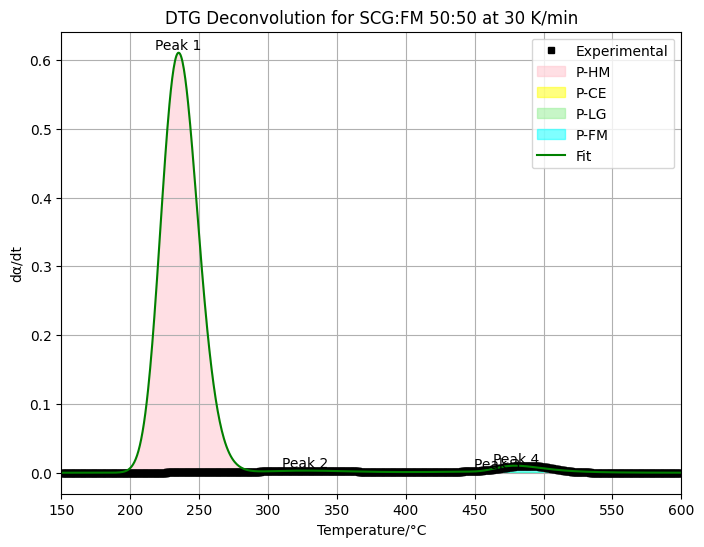

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 50:50...
No alpha points selected for Hemicellulose in range 0.014 to 0.025. Skipping.
Cellulose at α = 0.097: Ea = 178.72 kJ/mol (R² = 0.9428)
Cellulose at α = 0.147: Ea = 181.77 kJ/mol (R² = 0.9584)
Cellulose at α = 0.197: Ea = 178.72 kJ/mol (R² = 0.9556)
Cellulose at α = 0.247: Ea = 178.77 kJ/mol (R² = 0.9615)
Cellulose at α = 0.297: Ea = 175.31 kJ/mol (R² = 0.9639)
Lignin at α = 0.363: Ea = 169.00 kJ/mol (R² = 0.8546)
Lignin at α = 0.413: Ea = 171.90 kJ/mol (R² = 0.8574)
Lignin at α = 0.463: Ea = 176.41 kJ/mol (R² = 0.8604)
Lignin at α = 0.513: Ea = 178.18 kJ/mol (R² = 0.8590)
Lignin at α = 0.563: Ea = 180.79 kJ/mol (R² = 0.8562)
Lignin at α = 0.613: Ea = 184.48 kJ/mol (R² = 0.8590)
Lignin at α = 0.663: Ea = 186.72 kJ/mol (R² = 0.8603)
Lignin at α = 0.713: Ea = 192.03 kJ/mol (R² = 0.8633)
Lignin at α = 0.763: Ea = 194.62 kJ/mol (R² = 0.8578)
Lignin at α = 0.813: Ea = 198.89 kJ/mol (R² = 0.8579)
Lignin at α = 0.863: Ea = 207.51 kJ/mol (R² = 0.8651)
Li

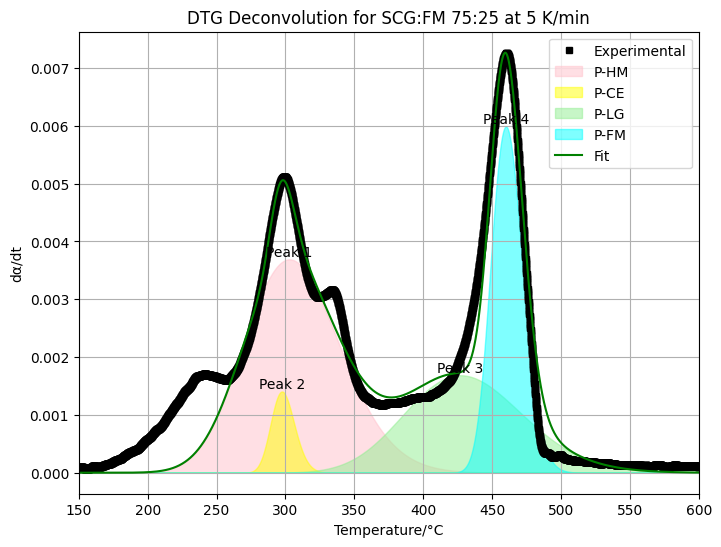

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 75:25...
Insufficient heating rates for Hemicellulose to apply KAS method (need at least 2).
Insufficient heating rates for Cellulose to apply KAS method (need at least 2).
Insufficient heating rates for Lignin to apply KAS method (need at least 2).
Insufficient heating rates for FM to apply KAS method (need at least 2).

Processing SCG:FM 75:25, Heating rate 10 K/min...
Raw data lengths - len(temp_c): 2701, len(tga): 2701, len(dtg): 2701
After temp filter - len(temp_c): 2701, len(tga): 2701, len(dtg): 2701
After alpha filter - len(temp_c): 2034, len(tga): 2034, len(dtg): 2034
SCG:FM 75:25: Fraser-Suzuki deconvolution successful at 10 K/min.
Peak 1 (Hemicellulose): Height: 0.0019, Position: 271.31°C, Width: 24.33, Asymmetry: 0.10
Peak 2 (Cellulose): Height: 0.0042, Position: 313.47°C, Width: 27.75, Asymmetry: 0.49
Peak 3 (Lignin): Height: 0.0015, Position: 437.13°C, Width: 50.00, Asymmetry: 0.10
Peak 4 (FM): Height: 0.0062, Position: 470.11°C, Width: 14.

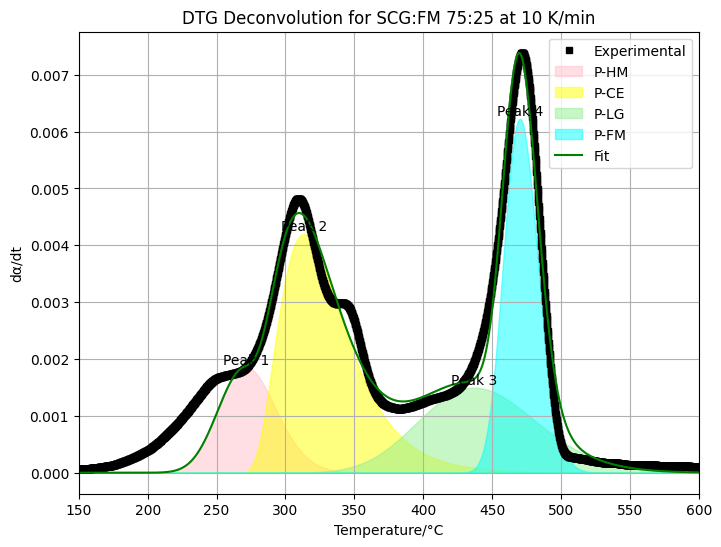

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 75:25...
Hemicellulose at α = 0.099: Ea = -110.00 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.149: Ea = -95.67 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.199: Ea = -86.79 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.249: Ea = -81.16 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.299: Ea = -76.79 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.349: Ea = -72.78 kJ/mol (R² = 1.0000)
Cellulose at α = 0.221: Ea = 125.89 kJ/mol (R² = 1.0000)
Cellulose at α = 0.271: Ea = 109.80 kJ/mol (R² = 1.0000)
Cellulose at α = 0.321: Ea = 97.24 kJ/mol (R² = 1.0000)
Cellulose at α = 0.371: Ea = 86.01 kJ/mol (R² = 1.0000)
Lignin at α = 0.499: Ea = 272.79 kJ/mol (R² = 1.0000)
Lignin at α = 0.549: Ea = 274.75 kJ/mol (R² = 1.0000)
Lignin at α = 0.599: Ea = 281.51 kJ/mol (R² = 1.0000)
Lignin at α = 0.649: Ea = 283.74 kJ/mol (R² = 1.0000)
Lignin at α = 0.699: Ea = 288.69 kJ/mol (R² = 1.0000)
Lignin at α = 0.749: Ea = 296.63 kJ/mol (R² = 1.0000)
Lignin at α = 0.799: Ea = 300.35 kJ/mol (R

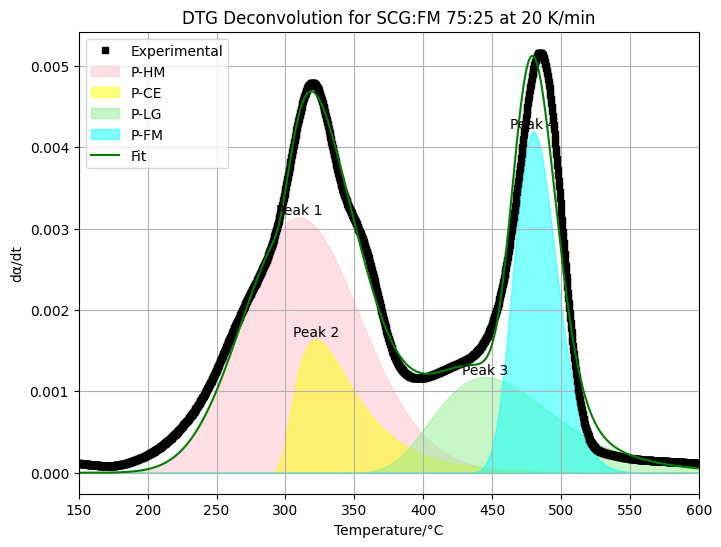

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 75:25...
Hemicellulose at α = 0.099: Ea = -32.52 kJ/mol (R² = 0.0299)
Hemicellulose at α = 0.149: Ea = -11.14 kJ/mol (R² = 0.0054)
Hemicellulose at α = 0.199: Ea = -3.63 kJ/mol (R² = 0.0008)
Hemicellulose at α = 0.249: Ea = 0.16 kJ/mol (R² = 0.0000)
Hemicellulose at α = 0.299: Ea = 2.12 kJ/mol (R² = 0.0004)
Hemicellulose at α = 0.349: Ea = 3.84 kJ/mol (R² = 0.0015)
Cellulose at α = 0.225: Ea = 135.43 kJ/mol (R² = 0.9976)
Cellulose at α = 0.275: Ea = 126.96 kJ/mol (R² = 0.9903)
Cellulose at α = 0.325: Ea = 118.23 kJ/mol (R² = 0.9790)
Cellulose at α = 0.375: Ea = 109.24 kJ/mol (R² = 0.9699)
Lignin at α = 0.597: Ea = 207.03 kJ/mol (R² = 0.9791)
Lignin at α = 0.647: Ea = 206.13 kJ/mol (R² = 0.9768)
Lignin at α = 0.697: Ea = 202.72 kJ/mol (R² = 0.9727)
Lignin at α = 0.747: Ea = 195.90 kJ/mol (R² = 0.9662)
Lignin at α = 0.797: Ea = 189.29 kJ/mol (R² = 0.9579)
Lignin at α = 0.847: Ea = 180.06 kJ/mol (R² = 0.9490)
Lignin at α = 0.897: Ea = 169.52 kJ/mol (R² = 0.

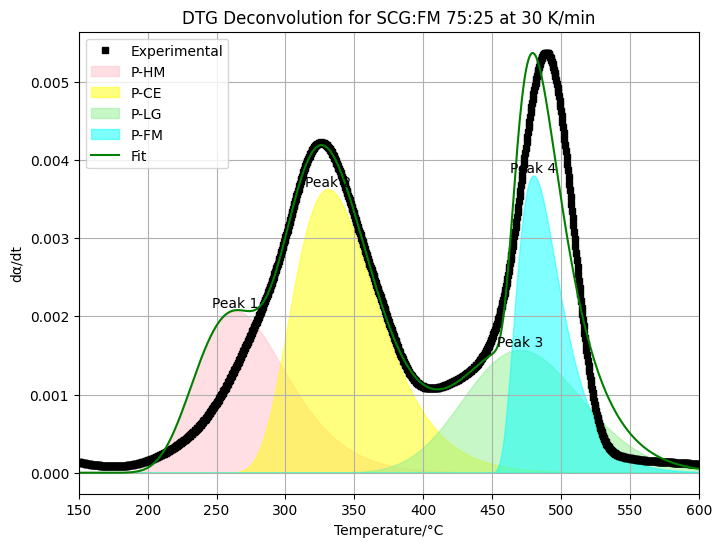

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 75:25...
Hemicellulose at α = 0.099: Ea = -92.13 kJ/mol (R² = 0.4728)
Hemicellulose at α = 0.149: Ea = -77.85 kJ/mol (R² = 0.3949)
Hemicellulose at α = 0.199: Ea = -68.92 kJ/mol (R² = 0.3386)
Hemicellulose at α = 0.249: Ea = -62.24 kJ/mol (R² = 0.2954)
Hemicellulose at α = 0.299: Ea = -56.80 kJ/mol (R² = 0.2620)
Hemicellulose at α = 0.349: Ea = -51.04 kJ/mol (R² = 0.2262)
Cellulose at α = 0.225: Ea = 160.92 kJ/mol (R² = 0.9245)
Cellulose at α = 0.275: Ea = 150.18 kJ/mol (R² = 0.9300)
Cellulose at α = 0.325: Ea = 139.47 kJ/mol (R² = 0.9303)
Cellulose at α = 0.375: Ea = 128.86 kJ/mol (R² = 0.9276)
Lignin at α = 0.597: Ea = 173.96 kJ/mol (R² = 0.9680)
Lignin at α = 0.647: Ea = 175.67 kJ/mol (R² = 0.9696)
Lignin at α = 0.697: Ea = 178.45 kJ/mol (R² = 0.9735)
Lignin at α = 0.747: Ea = 180.54 kJ/mol (R² = 0.9769)
Lignin at α = 0.797: Ea = 181.97 kJ/mol (R² = 0.9768)
Lignin at α = 0.847: Ea = 182.02 kJ/mol (R² = 0.9736)
Lignin at α = 0.897: Ea = 181.96 kJ/mol (

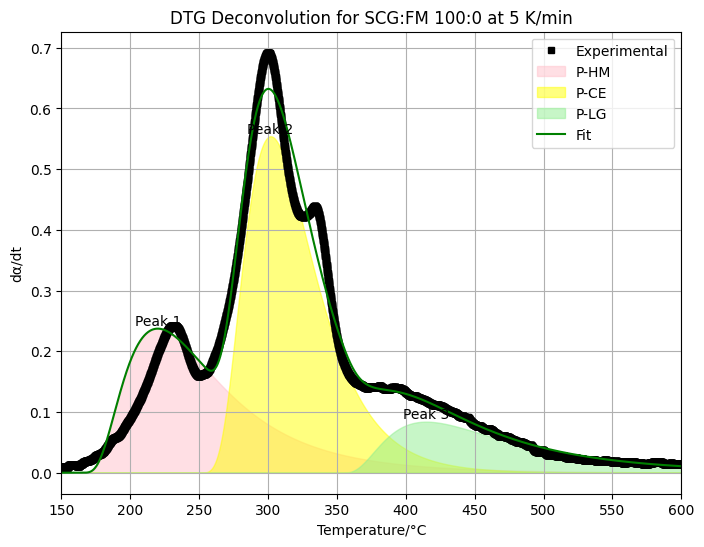

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 100:0...
Insufficient heating rates for Hemicellulose to apply KAS method (need at least 2).
Insufficient heating rates for Cellulose to apply KAS method (need at least 2).
Insufficient heating rates for Lignin to apply KAS method (need at least 2).

Processing SCG:FM 100:0, Heating rate 10 K/min...
Raw data lengths - len(temp_c): 2701, len(tga): 2701, len(dtg): 2701
After temp filter - len(temp_c): 2701, len(tga): 2701, len(dtg): 2701
After alpha filter - len(temp_c): 2146, len(tga): 2146, len(dtg): 2146
SCG:FM 100:0: Fraser-Suzuki deconvolution successful at 10 K/min.
Peak 1 (Hemicellulose): Height: 0.2432, Position: 240.17°C, Width: 50.00, Asymmetry: 0.50
Peak 2 (Cellulose): Height: 0.5067, Position: 312.31°C, Width: 29.54, Asymmetry: 0.54
Peak 3 (Lignin): Height: 0.0815, Position: 427.80°C, Width: 50.00, Asymmetry: 0.76
R² for fit at 10 K/min: 0.9901
Hemicellulose at 10 K/min: Alpha range = 0.005 to 0.878
Cellulose at 10 K/min: Alpha range = 0.204 to

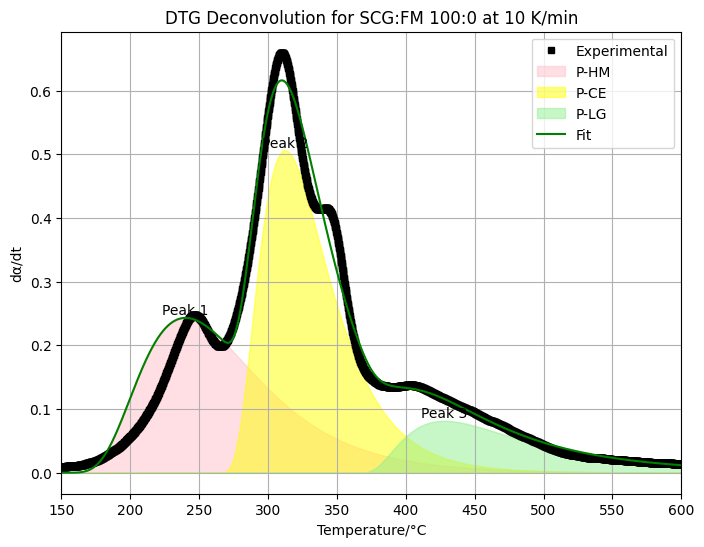

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 100:0...
Hemicellulose at α = 0.056: Ea = 174.53 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.106: Ea = 133.68 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.156: Ea = 116.44 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.206: Ea = 107.07 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.256: Ea = 99.93 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.306: Ea = 95.06 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.356: Ea = 91.88 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.406: Ea = 90.11 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.456: Ea = 89.06 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.506: Ea = 89.70 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.556: Ea = 89.49 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.606: Ea = 90.50 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.656: Ea = 93.22 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.706: Ea = 97.43 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.756: Ea = 103.46 kJ/mol (R² = 1.0000)
Hemicellulose at α = 0.806: Ea = 113.92 kJ/mol (R² = 1

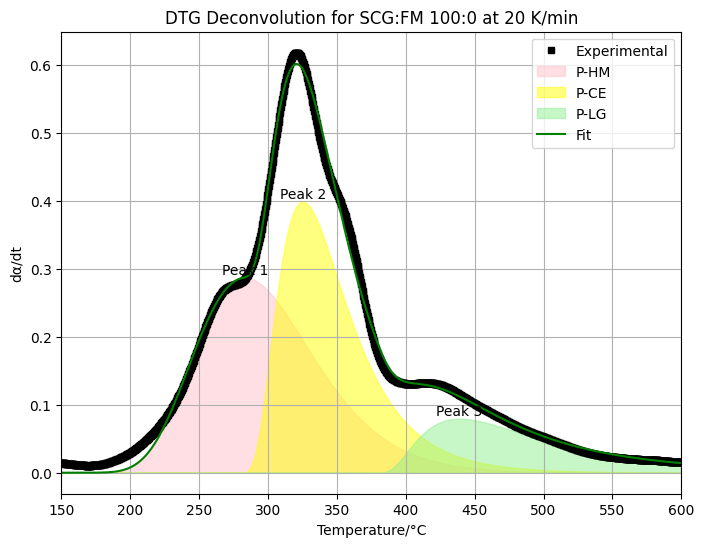

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 100:0...
Hemicellulose at α = 0.063: Ea = 50.79 kJ/mol (R² = 0.8552)
Hemicellulose at α = 0.113: Ea = 49.48 kJ/mol (R² = 0.8814)
Hemicellulose at α = 0.163: Ea = 49.48 kJ/mol (R² = 0.9010)
Hemicellulose at α = 0.213: Ea = 49.33 kJ/mol (R² = 0.9127)
Hemicellulose at α = 0.263: Ea = 49.87 kJ/mol (R² = 0.9226)
Hemicellulose at α = 0.313: Ea = 50.79 kJ/mol (R² = 0.9330)
Hemicellulose at α = 0.363: Ea = 51.59 kJ/mol (R² = 0.9405)
Hemicellulose at α = 0.413: Ea = 53.01 kJ/mol (R² = 0.9467)
Hemicellulose at α = 0.463: Ea = 54.27 kJ/mol (R² = 0.9519)
Hemicellulose at α = 0.513: Ea = 56.13 kJ/mol (R² = 0.9574)
Hemicellulose at α = 0.563: Ea = 58.66 kJ/mol (R² = 0.9632)
Hemicellulose at α = 0.613: Ea = 61.35 kJ/mol (R² = 0.9671)
Hemicellulose at α = 0.663: Ea = 65.60 kJ/mol (R² = 0.9721)
Hemicellulose at α = 0.713: Ea = 70.68 kJ/mol (R² = 0.9759)
Hemicellulose at α = 0.763: Ea = 78.63 kJ/mol (R² = 0.9813)
Hemicellulose at α = 0.813: Ea = 90.32 kJ/mol (R² = 0.9852)

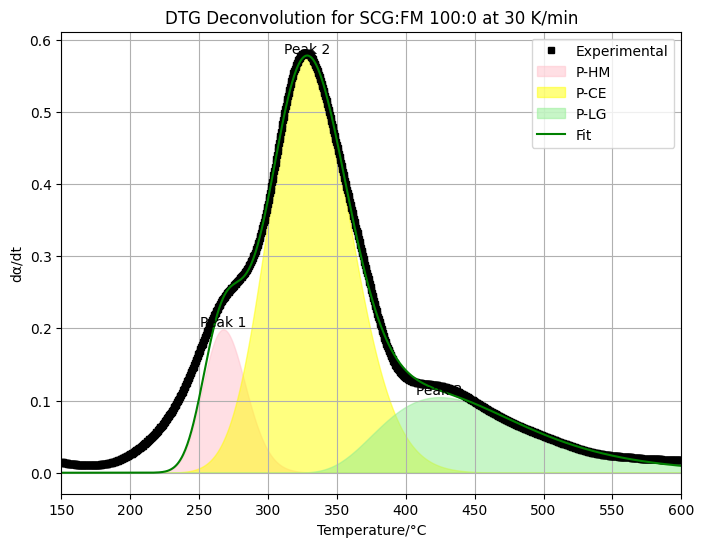

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Applying KAS method for SCG:FM 100:0...
Hemicellulose at α = 0.083: Ea = 54.58 kJ/mol (R² = 0.9236)
Hemicellulose at α = 0.133: Ea = 57.33 kJ/mol (R² = 0.9125)
Hemicellulose at α = 0.183: Ea = 59.23 kJ/mol (R² = 0.8890)
Hemicellulose at α = 0.233: Ea = 61.06 kJ/mol (R² = 0.8574)
Hemicellulose at α = 0.283: Ea = 62.32 kJ/mol (R² = 0.8178)
Cellulose at α = 0.271: Ea = 168.50 kJ/mol (R² = 0.6664)
Cellulose at α = 0.321: Ea = 173.47 kJ/mol (R² = 0.6936)
Cellulose at α = 0.371: Ea = 175.75 kJ/mol (R² = 0.7114)
Cellulose at α = 0.421: Ea = 177.86 kJ/mol (R² = 0.7284)
Cellulose at α = 0.471: Ea = 179.03 kJ/mol (R² = 0.7204)
Cellulose at α = 0.521: Ea = 179.80 kJ/mol (R² = 0.7240)
Cellulose at α = 0.571: Ea = 177.69 kJ/mol (R² = 0.6955)
Cellulose at α = 0.621: Ea = 175.99 kJ/mol (R² = 0.6718)
Cellulose at α = 0.671: Ea = 173.11 kJ/mol (R² = 0.6305)
Cellulose at α = 0.721: Ea = 165.74 kJ/mol (R² = 0.5771)
Cellulose at α = 0.771: Ea = 154.76 kJ/mol (R² = 0.5033)
Cellulose at α = 0.821: Ea = 136

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import linregress
from google.colab import files

# Universal gas constant (J/mol·K)
R = 8.314

# Prompt for file upload
print("Please upload 'Opitmization of copyrolysis_input.csv'")
uploaded = files.upload()

# Load the CSV file
df = pd.read_csv('Opitmization of copyrolysis_input.csv')

# Define temperature and alpha ranges
temp_range = [150, 600]  # As requested: 150–600°C
alpha_clip = [0, 1]  # Clip alpha to avoid numerical issues

# Dataframe to store KAS results for each peak
kas_results = []

# Initialize storage for fitted parameters
popt_storage = {}

# Group by SCG% to process all heating rates for each SCG:FM ratio
for scg, scg_group in df.groupby('SCG%'):
    sample_name = f"SCG:FM {int(scg)}:{int(100-scg)}"
    print(f"\nProcessing {sample_name} across all heating rates...")

    # Store data for KAS method across heating rates
    component_data = {}  # Dictionary to store {component: [(hr, temp, alpha, peak_curve), ...]}
    heating_rates = []

    # Process each heating rate for the current SCG%
    for hr, group in scg_group.groupby('Heating rate'):
        print(f"\nProcessing {sample_name}, Heating rate {hr} K/min...")

        # Extract arrays
        temp_c = group['Temperature'].values
        tga = group['TGA'].values
        dtg = group['DTG'].values  # Use experimental DTG from CSV

        # Debug: Check lengths of raw data
        print(f"Raw data lengths - len(temp_c): {len(temp_c)}, len(tga): {len(tga)}, len(dtg): {len(dtg)}")
        if len(temp_c) != len(tga) or len(temp_c) != len(dtg):
            print(f"Length mismatch in raw data. Skipping.")
            continue

        # Filter for the extended temperature range (150–600°C) and ensure finite values
        mask = (temp_c >= temp_range[0]) & (temp_c <= temp_range[1]) & np.isfinite(temp_c) & np.isfinite(tga) & np.isfinite(dtg)
        if not np.any(mask):
            print(f"No data in temperature range {temp_range[0]}–{temp_range[1]}°C. Skipping.")
            continue
        temp_c_full = temp_c[mask]
        tga_full = tga[mask]
        dtg_full = dtg[mask]
        temp_k_full = temp_c_full + 273.15

        # Debug: Check lengths after temperature filter
        print(f"After temp filter - len(temp_c): {len(temp_c_full)}, len(tga): {len(tga_full)}, len(dtg): {len(dtg_full)}")
        if len(temp_c_full) != len(tga_full) or len(temp_c_full) != len(dtg_full):
            print(f"Length mismatch after temperature filter. Skipping.")
            continue

        # Calculate conversion (α) for the full range
        m0 = tga_full[0]
        mf = tga_full[-1]
        if m0 <= mf:
            print(f"Invalid mass loss - m0 ({m0}) <= mf ({mf}). Skipping.")
            continue
        alpha_full = (m0 - tga_full) / (m0 - mf)
        alpha_full = np.clip(alpha_full, alpha_clip[0], alpha_clip[1])

        # Apply alpha filter for deconvolution (α >= 0.1)
        mask_alpha = (alpha_full >= 0.1) & (alpha_full <= 1.0) & np.isfinite(alpha_full)
        if not np.any(mask_alpha):
            print(f"No data for α ≥ 0.1. Alpha range: {alpha_full.min():.4f} to {alpha_full.max():.4f}. Skipping.")
            continue
        alpha = alpha_full[mask_alpha]
        temp_k = temp_k_full[mask_alpha]
        temp_c = temp_c_full[mask_alpha]
        tga = tga_full[mask_alpha]
        dtg = dtg_full[mask_alpha]

        # Debug: Check lengths after alpha filter
        print(f"After alpha filter - len(temp_c): {len(temp_c)}, len(tga): {len(tga)}, len(dtg): {len(dtg)}")
        if len(temp_c) != len(tga) or len(temp_c) != len(dtg):
            print(f"Length mismatch after alpha filter. Skipping.")
            continue

        # Check for non-finite values in temp_c and dtg
        if not np.all(np.isfinite(temp_c)) or not np.all(np.isfinite(dtg)):
            print(f"Non-finite values detected in temp_c or dtg after filtering. Skipping.")
            continue

        # Ensure enough data points for processing
        if len(dtg) < 3:
            print(f"Not enough data points after filtering (len(dtg) = {len(dtg)}). Skipping.")
            continue

        # Fraser-Suzuki deconvolution
        def fraser_suzuki(x, h, r, wr, sr):
            arg = (x - r) * sr / wr
            arg_safe = np.where(arg > -1, arg, -0.9999)  # Prevent log of negative numbers
            term = np.log(1 + arg_safe)
            exponent = -np.log(2) * (term / sr)**2
            exponent = np.clip(exponent, -500, 500)  # Prevent overflow in exp
            return h * np.exp(exponent)

        def multi_fraser_suzuki(x, *params):
            n_peaks = len(params) // 4  # 4 parameters per peak (h, r, wr, sr)
            y = np.zeros_like(x, dtype=float)
            for i in range(n_peaks):
                y += fraser_suzuki(x, *params[i*4:i*4+4])
            return y

        # Set number of peaks and initial guesses based on decomposition ranges
        n_peaks = 3 if scg > 0 else 1  # SCG: 3 peaks (hemicellulose, cellulose, lignin); FM: 1 peak
        dtg_max = dtg.max()
        initial_guesses = []
        if scg > 0:
            # Order: h, r, wr, sr
            # Hemicellulose: 220–310°C
            initial_guesses.extend([dtg_max * 0.3, 265, 30, 0.5])
            # Cellulose: 250–400°C
            initial_guesses.extend([dtg_max, 325, 30, 0.5])
            # Lignin: 220–600°C
            initial_guesses.extend([dtg_max * 0.4, 400, 100, 0.5])
        if scg < 100:
            if scg == 0:
                # FM only: 460–480°C
                initial_guesses = [dtg_max, 470, 20, 0.5]
            else:
                # FM in blends: 460–480°C
                initial_guesses.extend([dtg_max * 0.5, 470, 20, 0.5])

        # Define bounds for curve_fit based on decomposition ranges
        bounds_lower = []
        bounds_upper = []
        if scg > 0:
            # Hemicellulose: h, r, wr, sr
            bounds_lower.extend([0, 220, 10, 0.1])
            bounds_upper.extend([np.inf, 310, 50, 2.0])
            # Cellulose: 250–400°C
            bounds_lower.extend([0, 250, 10, 0.1])
            bounds_upper.extend([np.inf, 400, 50, 2.0])
            # Lignin: 220–600°C
            bounds_lower.extend([0, 220, 50, 0.1])
            bounds_upper.extend([np.inf, 600, 150, 2.0])
        if scg < 100:
            if scg == 0:
                # FM only
                bounds_lower = [0, 460, 10, 0.1]
                bounds_upper = [np.inf, 480, 30, 2.0]
            else:
                # FM in blends
                bounds_lower.extend([0, 460, 10, 0.1])
                bounds_upper.extend([np.inf, 480, 30, 2.0])
        bounds = (bounds_lower, bounds_upper)

        try:
            popt, _ = curve_fit(multi_fraser_suzuki, temp_c, dtg, p0=initial_guesses, bounds=bounds, maxfev=10000)
            print(f"{sample_name}: Fraser-Suzuki deconvolution successful at {hr} K/min.")
            component_labels = []
            if scg > 0:
                component_labels.extend(['Hemicellulose', 'Cellulose', 'Lignin'])
            if scg < 100:
                if scg == 0:
                    component_labels = ['FM']
                else:
                    component_labels.append('FM')
            for i in range(len(popt) // 4):
                print(f"Peak {i+1} ({component_labels[i]}): Height: {popt[i*4]:.4f}, Position: {popt[i*4+1]:.2f}°C, Width: {popt[i*4+2]:.2f}, Asymmetry: {popt[i*4+3]:.2f}")

            # Calculate R² to evaluate fit quality
            fit = multi_fraser_suzuki(temp_c, *popt)
            ss_res = np.sum((dtg - fit) ** 2)  # Residual sum of squares
            ss_tot = np.sum((dtg - np.mean(dtg)) ** 2)  # Total sum of squares
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0  # R² calculation
            print(f"R² for fit at {hr} K/min: {r2:.4f}")

            # Store the fitted parameters
            popt_storage[(int(scg), int(hr))] = popt

            # ... (rest of the code, including plotting and KAS analysis, remains the same) ...

            # Generate a temperature array from 150 to 600°C for plotting and peak analysis
            temp_c_plot = np.linspace(150, 600, len(temp_c_full))
            deconvoluted_peaks = [fraser_suzuki(temp_c_plot, *popt[i*4:i*4+4]) for i in range(len(popt) // 4)]

            # Map peaks to alpha ranges and collect data for KAS
            for i, (peak, label) in enumerate(zip(deconvoluted_peaks, component_labels)):
                # Determine temperature range where peak is significant (e.g., >5% of max height)
                threshold = 0.05 * peak.max()
                significant_indices = np.where(peak > threshold)[0]
                if len(significant_indices) == 0:
                    print(f"Warning: No significant range found for {label} at {hr} K/min.")
                    continue
                temp_start = temp_c_plot[significant_indices[0]]
                temp_end = temp_c_plot[significant_indices[-1]]

                # Map temperature range to alpha range using temp_c_full and alpha_full
                alpha_mask = (temp_c_full >= temp_start) & (temp_c_full <= temp_end)
                if not np.any(alpha_mask):
                    print(f"Warning: No alpha values found for {label} in range {temp_start:.1f}–{temp_end:.1f}°C at {hr} K/min.")
                    continue
                alpha_range = (alpha_full[alpha_mask].min(), alpha_full[alpha_mask].max())
                print(f"{label} at {hr} K/min: Alpha range = {alpha_range[0]:.3f} to {alpha_range[1]:.3f}")

                # Store data for KAS method
                if label not in component_data:
                    component_data[label] = []
                component_data[label].append((hr, temp_c_plot, alpha_full, peak))

            heating_rates.append(hr)

            # Plotting DTG deconvolution
            plt.figure(figsize=(8, 6))
            plt.plot(temp_c_full, dtg_full, 'ks', label='Experimental', markersize=4)
            if scg == 0:
                labels = ['P-FM']
                colors = ['cyan']
            elif scg == 100:
                labels = ['P-HM', 'P-CE', 'P-LG']
                colors = ['pink', 'yellow', 'lightgreen']
            else:
                labels = ['P-HM', 'P-CE', 'P-LG', 'P-FM']
                colors = ['pink', 'yellow', 'lightgreen', 'cyan']
            for i, (peak, label, color) in enumerate(zip(deconvoluted_peaks, labels[:len(deconvoluted_peaks)], colors)):
                plt.fill_between(temp_c_plot, 0, peak, color=color, alpha=0.5, label=label)
                peak_max_idx = np.argmax(peak)
                plt.text(temp_c_plot[peak_max_idx], peak[peak_max_idx], f'Peak {i+1}', ha='center', va='bottom')
            fit = multi_fraser_suzuki(temp_c_plot, *popt)
            plt.plot(temp_c_plot, fit, 'g-', label='Fit')
            plt.xlim(150, 600)
            plt.xlabel('Temperature/°C')
            plt.ylabel('dα/dt')
            plt.title(f'DTG Deconvolution for {sample_name} at {hr} K/min')
            plt.legend()
            plt.grid(True)
            filename = f'deconvolution_dtg_scg{int(scg)}_hr{int(hr)}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.show()
            files.download(filename)
####################################### END OF FRAIZER-SUZUKI DECONVOLUTION #################################################
            # Apply KAS method for each component
            print(f"\nApplying KAS method for {sample_name}...")
            for component, data_list in component_data.items():
                if len(data_list) < 2:
                    print(f"Insufficient heating rates for {component} to apply KAS method (need at least 2).")
                    continue

                # Determine the common alpha range for this component across all heating rates
                alpha_ranges = []
                for hr, temp_c_plot, alpha_full, peak in data_list:
                    threshold = 0.05 * peak.max()
                    significant_indices = np.where(peak > threshold)[0]
                    if len(significant_indices) == 0:
                        continue
                    temp_start = temp_c_plot[significant_indices[0]]
                    temp_end = temp_c_plot[significant_indices[-1]]
                    alpha_mask = (temp_c_plot >= temp_start) & (temp_c_plot <= temp_end)
                    alpha_range = (alpha_full[alpha_mask].min(), alpha_full[alpha_mask].max())
                    alpha_ranges.append(alpha_range)

                if not alpha_ranges:
                    print(f"No valid alpha ranges for {component}. Skipping KAS method.")
                    continue

                # Find the intersection of alpha ranges (conservative approach)
                alpha_min = max(ar[0] for ar in alpha_ranges)
                alpha_max = min(ar[1] for ar in alpha_ranges)
                if alpha_min >= alpha_max:
                    print(f"No overlapping alpha range for {component}. Skipping KAS method.")
                    continue

                # Select alpha points for KAS analysis (e.g., every 0.05 within the range)
                alpha_points = np.arange(alpha_min + 0.05, alpha_max, 0.05)
                if len(alpha_points) == 0:
                    print(f"No alpha points selected for {component} in range {alpha_min:.3f} to {alpha_max:.3f}. Skipping.")
                    continue

                # Apply KAS method at each alpha
                for alpha_target in alpha_points:
                    temps_at_alpha = []
                    valid_hrs = []
                    for hr, temp_c_plot, alpha_full, peak in data_list:
                        # Find the temperature at which this alpha occurs on the deconvoluted peak
                        peak_cumsum = np.cumsum(peak)
                        if peak_cumsum[-1] == 0:
                            continue
                        peak_alpha = peak_cumsum / peak_cumsum[-1]  # Normalized cumulative peak as "conversion"
                        idx = np.argmin(np.abs(peak_alpha - alpha_target))
                        if idx == 0 or idx == len(peak_alpha) - 1:
                            continue  # Skip if alpha_target is at the boundaries
                        T_c = temp_c_plot[idx]
                        T_k = T_c + 273.15
                        temps_at_alpha.append(T_k)
                        valid_hrs.append(hr)

                    if len(temps_at_alpha) < 2:
                        print(f"Insufficient data points for {component} at α = {alpha_target:.3f}. Skipping.")
                        continue

                    # KAS method: ln(beta/T^2) vs 1/T
                    x = 1 / np.array(temps_at_alpha)  # 1/T (K^-1)
                    y = np.log(np.array(valid_hrs) / np.array(temps_at_alpha)**2)  # ln(beta/T^2)
                    slope, intercept, r_value, p_value, std_err = linregress(x, y)
                    Ea = -slope * R / 1000  # Ea in kJ/mol
                    r2 = r_value**2

                    print(f"{component} at α = {alpha_target:.3f}: Ea = {Ea:.2f} kJ/mol (R² = {r2:.4f})")

                    # Store KAS result
                    kas_results.append({
                        'SCG:FM Ratio': sample_name,
                        'Component': component,
                        'Alpha': alpha_target,
                        'Ea (kJ/mol)': Ea,
                        'R²': r2
                    })

        except RuntimeError as e:
            print(f"{sample_name}: Fraser-Suzuki deconvolution failed at {hr} K/min: {e}. Skipping.")
            continue

# Create and download CSV file with KAS results
if kas_results:
    kas_df = pd.DataFrame(kas_results)
    csv_filename = 'peak_KAS_results.csv'
    kas_df.to_csv(csv_filename, index=False)
    print(f"\nDownloading {csv_filename}...")
    files.download(csv_filename)
else:
    print("\nNo KAS results to export.")